In [2]:
import os, types
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

In [3]:
def boxcar_average(a, n=3):
    na = len(a)
    b = np.zeros(a.shape)
    for i in range(na):
        sum = 0.0
        for j in range(-n, n+1):
            idx = i + j
            if idx < 0:
                idx = 0
            if idx > na-1:
                idx = na - 1
            sum += a[idx]
        b[i] = sum/(2.0*n+1.0) 
    return b

def load_weather_region(region, nw):
    load_weather = pd.read_csv('./data/load_weather_'+region+'.csv')
    # create time-lage load data for time-series learning
    for lag in lags:
        load_weather[f'load_lag{lag}'] = load_weather.shift(periods=lag)['load']
    # apply simple smoothing to de-noise tempature 
    load_weather['temp'] = boxcar_average(load_weather['temp'],nw)
    load_weather = load_weather.set_index('date_time')
    return load_weather

def load_target(df, region):
    return df[region]

def split_train_test(df, trainstart, teststart):
    mask = (df.index >= trainstart) & (df.index < teststart)
    df_train = df.loc[mask]
    mask = (df.index >= teststart) & (df.index <= df.index[-1])
    df_test = df.loc[mask]
    ytrain = df_train['load']
    xtrain = df_train.drop(['load'], axis=1)
    xtest = df_test.drop(['load'], axis=1)
    return xtrain, xtest, ytrain

def split_train_test2(df, trainstart, trainend, teststart, testend):
    mask = (df.index >= trainstart) & (df.index <= trainend)
    df_train = df.loc[mask]
    mask = (df.index >= teststart) & (df.index <= testend)
    df_test = df.loc[mask]
    ytrain = df_train['load']
    xtrain = df_train.drop(['load'], axis=1)
    ytest = df_test['load']
    xtest = df_test.drop(['load'], axis=1)
    return xtrain, xtest, ytrain, ytest

In [4]:
regions = ['Coast', 'East', 'Far West', 'North', 'North Central', 'South', 'South Central', 'West']
lags = np.arange(1,49)
lags = np.concatenate((lags,[72,96,120,144,168]))
lags

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  72,  96, 120, 144,
       168])

# Load target data

In [5]:
load_future = pd.read_csv('./data/gt_hourly_load.csv')
load_future = load_future.set_index('date_time')

In [6]:
rms_load = (load_future**2.0).sum().sum()/(168*8)
rms_load = rms_load**0.5
print(f'rms load in the week between 2021-06-20 and 2021-06-26: {rms_load}')

rms load in the week between 2021-06-20 and 2021-06-26: 9283.289088921685


# Model Building

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

- use history data to train a model
- validate with the data from one week before prediction window

region: Coast, r2 score: 0.9968430892625387
region: East, r2 score: 0.9950845145685941
region: Far West, r2 score: 0.9816200258772785
region: North, r2 score: 0.9983040286825495
region: North Central, r2 score: 0.9982460695247909
region: South, r2 score: 0.9979562729633824
region: South Central, r2 score: 0.9974758250985561
region: West, r2 score: 0.9976670485110791
rmse: 88.09060274496443


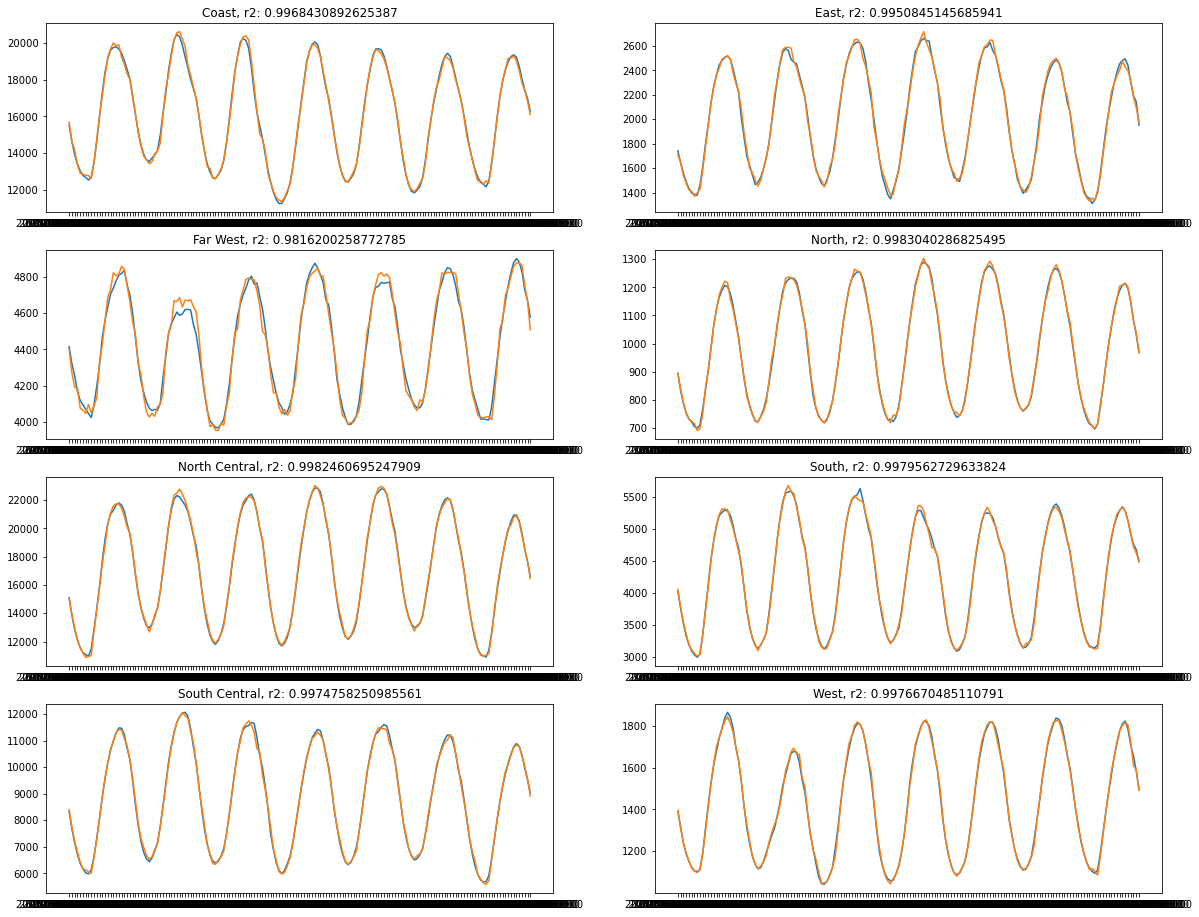

In [24]:
train_start = '2012-06-17 00:00:00'
train_end = '2021-06-12 23:00:00'
test_start = '2021-06-13 00:00:00'
test_end = '2021-06-19 23:00:00'
smooth_window=1
fig, axs = plt.subplots(4,2,figsize=(20,16))
rmse = 0.0

for i, region in enumerate(regions):
    load_weather_xgb = load2_weather_region(region, smooth_window) # load, feature enginering
    xtrain, xtest, ytrain, ytest = split_train_test2(load_weather_xgb, train_start, train_end, test_start, test_end)

    xgb = XGBRegressor(
        max_depth=6, # Default - 6
        min_child_weight = 5,
        n_estimators=1000,
        booster='gbtree',
        colsample_bytree=1, # Subsample ratio of columns when constructing each tree - default 1
        eta=0.3, # Learning Rate - default 0.3
        importance_type='gain' # Default is gain
    )

    xgb.fit(
        xtrain,
        ytrain,
        eval_set=[(xtrain, ytrain)],
        eval_metric='rmse',
        verbose=False,
        early_stopping_rounds=50 # Stop after 100 rounds if it doesn't after 100 times
    )

    ypred = xgb.predict(xtest)
    r2 = r2_score(ytest, ypred)
    print(f'region: {region}, r2 score: {r2}')
    rmse += ((ytest-ypred)**2).sum()
    #ytest = ytest.reset_index()
    #ytest.drop(ytest.columns.difference(['load']), 1, inplace=True)
    #ytest = ytest.squeeze()
    #ypred = ypred.reset_index()
    #ypred.drop(ypred.columns.difference(['load']), 1, inplace=True)
    #ypred = ypred.squeeze()
    axs[(int)(i/2),(i%2)].plot(ytest)
    axs[(int)(i/2),(i%2)].plot(ypred)
    axs[(int)(i/2),(i%2)].set_title(region+f', r2: {r2}')

rmse = rmse/(168*8)
rmse = rmse**0.5
print(f'rmse: {rmse}')

- retrain the model with all history data
- test in the prediction window with weather forecast

In [8]:
def recursive_pred(model, xtest, lags):
    n = xtest.shape[0]
    nlag = lags.shape[0]
    ypred = np.zeros(n)
    for i in range(n):
        ypred[i] = model.predict(xtest.iloc[i:i+1])
        for k, lag in enumerate(lags):
            j = i + lag 
            if(j<n):
                xtest.iloc[j, k+12] = ypred[i]
    return ypred

<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: Coast, r2 score: 0.9245785786333983


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: East, r2 score: 0.6891255094684217


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: Far West, r2 score: 0.38226956945317847


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: North, r2 score: 0.7649697874487615


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: North Central, r2 score: 0.9255103938319059


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: South, r2 score: 0.8781416092336163


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: South Central, r2 score: 0.8840914286458508


<ipython-input-9-8876fe2cffa3>:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ytest.drop(ytest.columns.difference([region]), 1, inplace=True)


region: West, r2 score: 0.9146773136058508
rmse: 460.83320937273857
rmse: 4.964115680967847%


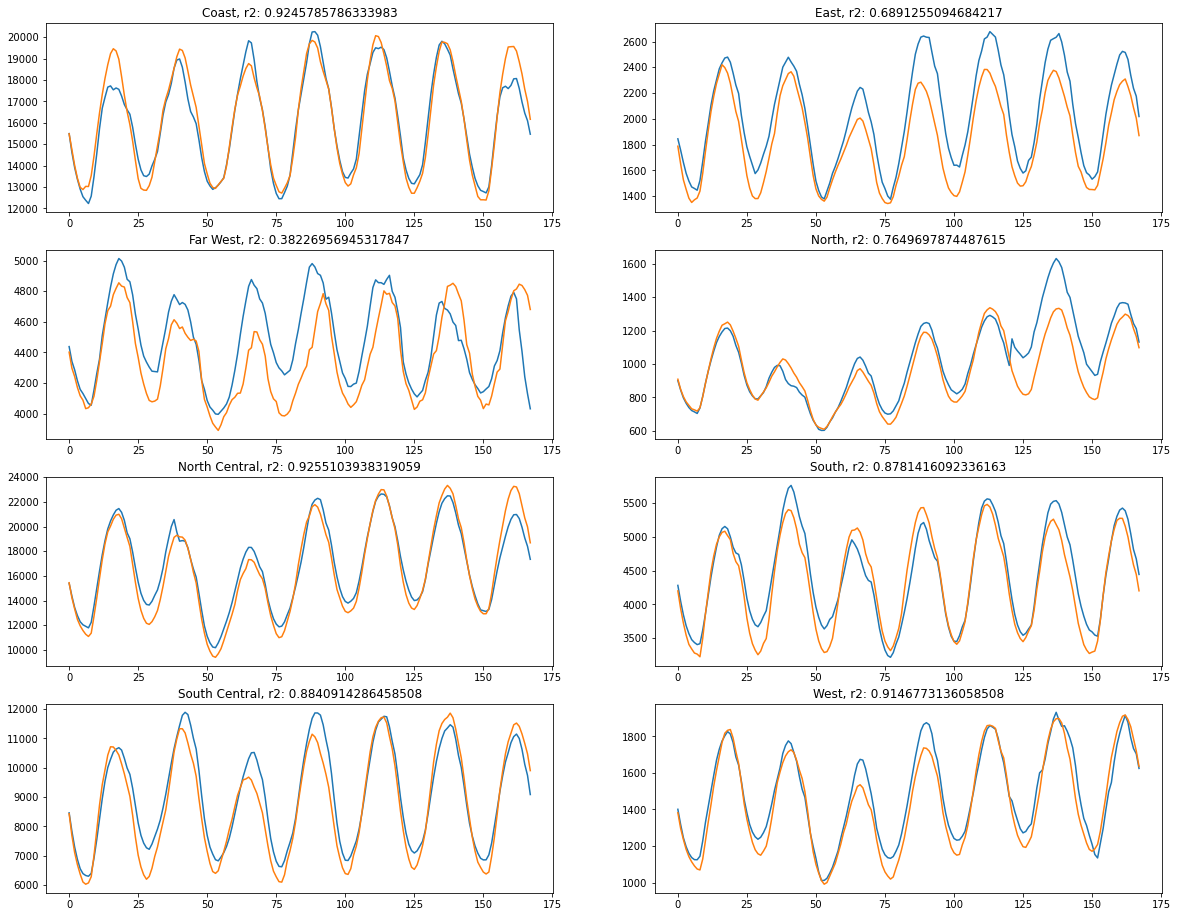

In [9]:
train_start = '2008-07-01 00:00:00'
train_end = '2021-06-19 23:00:00'
test_start = '2021-06-20 00:00:00'
test_end = '2021-06-26 23:00:00'
smooth_window=1
fig, axs = plt.subplots(4,2,figsize=(20,16))
rmse = 0.0
#for i, region in enumerate(['Coast']):
for i, region in enumerate(regions):
    load_weather_xgb = load_weather_region(region, smooth_window) # load, feature enginering
    xtrain, xtest, ytrain = split_train_test(load_weather_xgb, train_start, test_start)
    ytest = load_target(load_future, region)
    ytest = ytest.reset_index()
    ytest.drop(ytest.columns.difference([region]), 1, inplace=True)
    ytest = ytest.squeeze()
    
    xgb = XGBRegressor(
        max_depth=6, # Default - 6
        min_child_weight = 5,
        n_estimators=1000,
        booster='gbtree',
        colsample_bytree=1, # Subsample ratio of columns when constructing each tree - default 1
        eta=0.3, # Learning Rate - default 0.3
        importance_type='weight' # Default is gain
    )

    xgb.fit(
        xtrain,
        ytrain,
        eval_set=[(xtrain, ytrain)],
        eval_metric='rmse',
        verbose=False,
        early_stopping_rounds=50 # Stop after 100 rounds if it doesn't after 100 times
    )

    ypred = recursive_pred(xgb, xtest, lags)
    
    r2 = r2_score(ytest, ypred)
    print(f'region: {region}, r2 score: {r2}')
    
    rmse += ((ytest-ypred)**2).sum()
    axs[(int)(i/2),(i%2)].plot(ytest)
    axs[(int)(i/2),(i%2)].plot(ypred)
    axs[(int)(i/2),(i%2)].set_title(region+f', r2: {r2}')

rmse = rmse/(168*8)
rmse = rmse**0.5
print(f'rmse: {rmse}')
print(f'rmse: {rmse/rms_load*100.0}%')

# Compare actural temperature vs. forecast temperature
- this largely explains the misfit between the predicted load and actural load
- especially in East and Far West zones

In [11]:
from meteostat import Point, Stations, Hourly

In [16]:
start = datetime(2021, 6, 20)
end = datetime(2021, 6, 26, 23, 0)
forecast_start = '2021-06-20 00:00:00'
forecast_end = '2021-06-26 23:00:00'
time_dict = {0:'00:00:00', 300:'03:00:00', 600:'06:00:00', 900:'09:00:00',
             1200:'12:00:00', 1500:'15:00:00', 1800:'18:00:00', 2100:'21:00:00'}          


In [17]:
stations = {'Abilene':'72266', 'Austin':'72254', 'Brownsville':'72250', 'Corpus Christi':'72251', 'Dallas':'72259',
       'Houston':'72243', 'Midland':'72265', 'San Antonio':'72253', 'Tyler':'KTYR0', 'Wichita Falls':'72351'}
regions = {'Coast':'Houston', 'East':'Tyler', 'Far West':'Midland', 'North':'Wichita Falls',
           'North Central':'Dallas', 'South':'Corpus Christi', 'South Central':'San Antonio', 'West':'Abilene'}

In [23]:
def weather_data_prepare(weather_df1):
    weather_df1= weather_df1.replace({'time':time_dict})
    weather_df1['date_time'] = weather_df1['date'] + ' ' + weather_df1['time']
    weather_df1['date_time'] = pd.to_datetime(weather_df1['date_time'])
    weather_df1['temp'] = weather_df1['tempC']
    weather_df1.drop(weather_forecast_df.columns.difference(['date_time','city','temp']), 1, inplace=True)
    return weather_df1

def get_weather_city(df, city):
    weather_df_city = df[df['city']==city]
    weather_df_city = weather_df_city.resample("1H", origin=datetime(2008,7,1,0)).mean().interpolate('linear').ffill()
    return weather_df_city

In [24]:
weather_forecast_df = pd.read_csv('./data/weather_forecast.csv')
weather_forecast_df = weather_data_prepare(weather_forecast_df)
weather_forecast_df = weather_forecast_df.set_index('date_time')

In [26]:
def get_weather_from_meteostat(staion, city, start, end):
    weather = Hourly(stations.get(city), start, end)
    weather = weather.normalize()
    weather = weather.fetch()
    weather.drop(weather.columns.difference(['time','temp']), 1, inplace=True)
    weather = weather.fillna(method='ffill')
    weather = weather.shift(-5) # a lag is needed to match with provided weather history data.
    weather = weather.dropna()
    weather.index.name='date_time'
    return weather

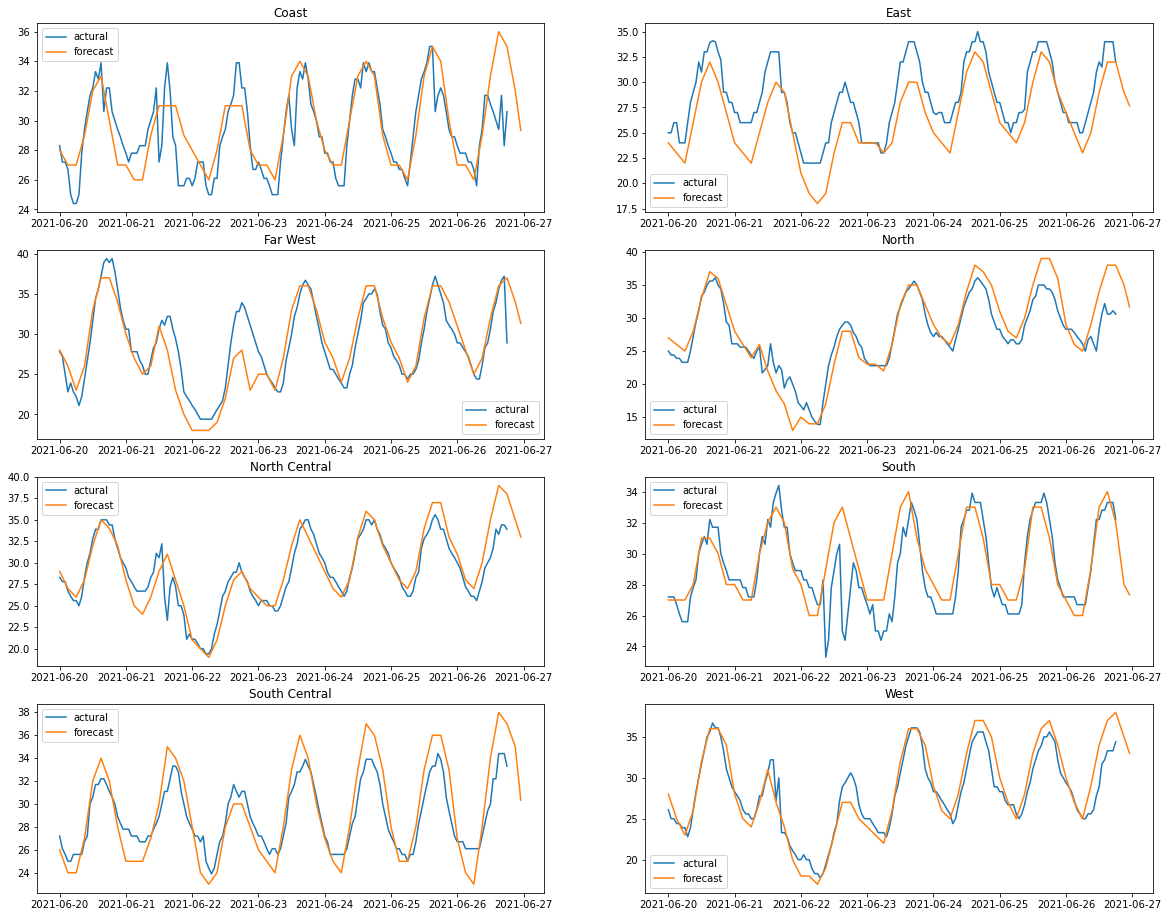

In [33]:
fig, axs = plt.subplots(4,2,figsize=(20,16))
i = 0
for region, city in regions.items():
    weather = get_weather_from_meteostat(stations.get(city), city, start, end)
    forecast = get_weather_city(weather_forecast_df, city)
    forecast = forecast[pd.Timestamp(forecast_start):pd.Timestamp(forecast_end)]
    axs[(int)(i/2),(i%2)].plot(weather, label='actural')
    axs[(int)(i/2),(i%2)].plot(forecast, label='forecast')
    axs[(int)(i/2),(i%2)].set_title(region)
    #axs[(int)(i/2),(i%2)].legend(loc='upper left')
    axs[(int)(i/2),(i%2)].legend()
    i = i + 1

# TODO: tuning